# Lab 6: Building A RAG Agent

## Setup Components

In [1]:
## Load Environment Table
from dotenv import load_dotenv
load_dotenv(override=True)  # take environment variables

True

In [2]:
# Load large language model 
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4.1-nano", model_provider="openai")

In [3]:
%pip install langchain_huggingface

Note: you may need to restart the kernel to use updated packages.


In [26]:
# Selecting Embedding model
# from langchain_openai import OpenAIEmbeddings
# embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

from langchain_huggingface import HuggingFaceEmbeddings
# embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
embedding_model = HuggingFaceEmbeddings(model_name="intfloat/multilingual-e5-large-instruct")
# embedding_model = HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-Qwen2-7B-instruct")

In [ ]:
#from langchain_openai import OpenAIEmbeddings
#embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [27]:
# Initiate Vector Code
# In-memory 

from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embedding_model)

## Document Loaders

In [6]:
%pip install -qU pypdf

Note: you may need to restart the kernel to use updated packages.


In [7]:
##
file_path = "./docs/Tentang Dexa Medica.pdf"

from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    pages.append(page)

In [8]:
print(f"{pages[0].metadata}\n")
print(pages[0].page_content)

{'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 0, 'page_label': '1'}

Gambaran Umum
Dexa Medica, salah satu perusahaan farmasi terbesar di Indonesia, telah secara konsisten
menggunakan kemampuan penelitiannya yang canggih untuk memprioritaskan kebutuhan
kesehatan masyarakat Indonesia. Mottonya — pemanfaatan keahlian untuk mempromosikan
kesehatan — adalah konsekuensi alami dari komitmen jangka panjangnya meningkatkan
perawatan kesehatan bagi semua orang. Perusahaan dan tim manajemen Dexa Medica dipandu
oleh empat prinsip inti yaitu kejujuran, kepercayaan, dedikasi, dan komitmen.
Dexa Medica didirikan di Palembang (Sumatera Selatan, Indonesia) pada tahun 1969 oleh
almarhum Letkol apt. D

In [9]:
docs = loader.load()
docs

[Document(metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 0, 'page_label': '1'}, page_content='Gambaran Umum\nDexa Medica, salah satu perusahaan farmasi terbesar di Indonesia, telah secara konsisten\nmenggunakan kemampuan penelitiannya yang canggih untuk memprioritaskan kebutuhan\nkesehatan masyarakat Indonesia. Mottonya — pemanfaatan keahlian untuk mempromosikan\nkesehatan — adalah konsekuensi alami dari komitmen jangka panjangnya meningkatkan\nperawatan kesehatan bagi semua orang. Perusahaan dan tim manajemen Dexa Medica dipandu\noleh empat prinsip inti yaitu kejujuran, kepercayaan, dedikasi, dan komitmen.\nDexa Medica didirikan di Palembang (Sumatera Selatan, Indonesia) pad

## Splitting

In [10]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=100
)

all_splits = text_splitter.split_documents(docs)

len(all_splits)

18

In [11]:
for split in all_splits:
    print(split)

page_content='Gambaran Umum
Dexa Medica, salah satu perusahaan farmasi terbesar di Indonesia, telah secara konsisten
menggunakan kemampuan penelitiannya yang canggih untuk memprioritaskan kebutuhan
kesehatan masyarakat Indonesia. Mottonya — pemanfaatan keahlian untuk mempromosikan
kesehatan — adalah konsekuensi alami dari komitmen jangka panjangnya meningkatkan
perawatan kesehatan bagi semua orang. Perusahaan dan tim manajemen Dexa Medica dipandu' metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 0, 'page_label': '1'}
page_content='perawatan kesehatan bagi semua orang. Perusahaan dan tim manajemen Dexa Medica dipandu
oleh empat prinsip inti yaitu kejujuran, kepercayaan, dedikasi

## Embedding and Indexing

In [28]:
vector_store.add_documents(all_splits)

['7bb54d15-6d9d-45d4-88a1-22ec6b624f89',
 '7ef36d58-1fcf-4b95-a3b1-3e9ba86e8722',
 '7e66eadf-9757-4614-87b9-57b59c7a9a81',
 'b9cc8cb4-27bb-4ecb-85c1-1804e945613b',
 '17d14170-686a-463b-b333-975c2a9df7bf',
 'b0222152-ac11-4256-a32e-82afa236ded3',
 'ec85eebb-3359-4f89-baa4-5dce539b237a',
 '90f3818b-980a-4f95-b3ea-9a148c90b406',
 '49d02e2a-caa6-4cdc-b6a5-d4dac5ab47f5',
 '4d4dc849-3a2b-41ae-ba52-2f0c250147a3',
 '1e12ba51-19e0-4e0d-81c6-9c49567852df',
 '4e32d4de-ebb1-4df9-a522-33c9bad37afd',
 '842e0b21-65af-46e8-9323-96699b4e1def',
 '3d13511e-ce1a-40c1-b4cb-2a92be097dab',
 'a78f1ab8-7cd9-4bcf-91ab-73569eb9ad62',
 '09f1f6a0-d414-4106-9c0d-535b34090002',
 'd1176e79-d30b-41d4-9224-f75186726daa',
 '01f46d77-f06d-450d-8c12-ad8d29439346']

In [13]:
vector_store.similarity_search("siapa pendiri Dexa Medica")

[Document(id='e2494cbd-3e89-4e6d-bc62-41451991899a', metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 0, 'page_label': '1'}, page_content='perawatan kesehatan bagi semua orang. Perusahaan dan tim manajemen Dexa Medica dipandu\noleh empat prinsip inti yaitu kejujuran, kepercayaan, dedikasi, dan komitmen.\nDexa Medica didirikan di Palembang (Sumatera Selatan, Indonesia) pada tahun 1969 oleh\nalmarhum Letkol apt. Drs. Rudy Soetikno. Sebagai seorang apoteker muda yang rendah hati di\nKorps Kesehatan/Medis TNI Angkatan Darat, beliau tergerak melihat kelangkaan pasokan obat-'),
 Document(id='dd90ad2a-7075-4ca4-98e8-93d779422f7b', metadata={'producer': 'Skia/PDF m136', 'creator': 'Moz

## Defining Nodes

In [29]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=5)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [30]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Keep the answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [31]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(MessagesState)
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

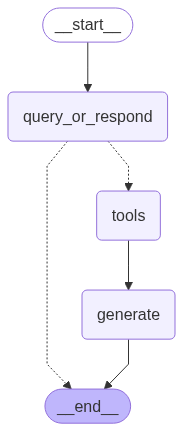

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I help you today?


In [19]:
config = {"configurable": {"thread_id": "1"}}

input_message = "Siapa pendiri Dexa Medica?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Siapa pendiri Dexa Medica?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_vZ637fnFag350fChYbFOl9lU)
 Call ID: call_vZ637fnFag350fChYbFOl9lU
  Args:
    query: Pendiri Dexa Medica
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 3, 'page_label': '4'}
Content: dari 31 fitofarmaka yang terdaftar adalah hasil produksi Dexa.
OGB
PT Dexa Medica adalah perusahaan swasta pertama di Indonesia yang memproduksi Obat
Generik Berlogo/OGB (obat generik ti

In [20]:
input_message = "dimana Dexa Medica didirikan?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

dimana Dexa Medica didirikan?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_Un1ojy4fFQXhxgUfRyc6InkJ)
 Call ID: call_Un1ojy4fFQXhxgUfRyc6InkJ
  Args:
    query: Dexa Medica didirikan
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 3, 'page_label': '4'}
Content: dari 31 fitofarmaka yang terdaftar adalah hasil produksi Dexa.
OGB
PT Dexa Medica adalah perusahaan swasta pertama di Indonesia yang memproduksi Obat
Generik Berlogo/OGB (obat gener

In [21]:
input_message = "Sebutkan 4 kompetensi inti yang dimiliki Dexa Medica."

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Sebutkan 4 kompetensi inti yang dimiliki Dexa Medica.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_glkaQCtk9Wu6VcqzYRZYwozX)
 Call ID: call_glkaQCtk9Wu6VcqzYRZYwozX
  Args:
    query: 4 kompetensi inti Dexa Medica
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 3, 'page_label': '4'}
Content: dari 31 fitofarmaka yang terdaftar adalah hasil produksi Dexa.
OGB
PT Dexa Medica adalah perusahaan swasta pertama di Indonesia yang memproduksi Obat

In [22]:
input_message = "Apa saja kontribusi yang sudah dilakukan oleh Dexa Medica?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Apa saja kontribusi yang sudah dilakukan oleh Dexa Medica?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_RQgMa2C2dNomUxcgH3ALWIdv)
 Call ID: call_RQgMa2C2dNomUxcgH3ALWIdv
  Args:
    query: kontribusi Dexa Medica
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 3, 'page_label': '4'}
Content: dari 31 fitofarmaka yang terdaftar adalah hasil produksi Dexa.
OGB
PT Dexa Medica adalah perusahaan swasta pertama di Indonesia yang memproduksi Obat
G

In [23]:
input_message = "Carikan informasi tentang Dexa Medica. Meliputi Motto, lokasi, dan pendiri."

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Carikan informasi tentang Dexa Medica. Meliputi Motto, lokasi, dan pendiri.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_S34jw7aqbNTvKPK23eP8ZEX2)
 Call ID: call_S34jw7aqbNTvKPK23eP8ZEX2
  Args:
    query: Dexa Medica
  retrieve (call_VZa7AFoPM5GlEAuA4Dg5dbIs)
 Call ID: call_VZa7AFoPM5GlEAuA4Dg5dbIs
  Args:
    query: Motto Dexa Medica
  retrieve (call_KQ433cRkKUEjTNxTyLpbHJY1)
 Call ID: call_KQ433cRkKUEjTNxTyLpbHJY1
  Args:
    query: Lokasi Dexa Medica
  retrieve (call_ozMFeX1OU5vrvddeCWbZDXOJ)
 Call ID: call_ozMFeX1OU5vrvddeCWbZDXOJ
  Args:
    query: Pendiri Dexa Medica
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'crea

In [33]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "2"}}

input_message = "sebutkan visi dan misi Dexa Medica"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

sebutkan visi dan misi Dexa Medica
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_B3qR2t405a8BYNrWd7ZvcbWC)
 Call ID: call_B3qR2t405a8BYNrWd7ZvcbWC
  Args:
    query: visi dan misi Dexa Medica
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 0, 'page_label': '1'}
Content: Sejak saat itu, Dexa Medica semakin kuat, berkembang menjadi salah satu perusahaan farmasi
etis terbesar di Indonesia. Lingkungan perusahaan yang dibina dengan cermat oleh 

### Check Similarity Search

In [25]:
vector_store.similarity_search("sebutkan visi dan misi Dexa Medica")

[Document(id='e2494cbd-3e89-4e6d-bc62-41451991899a', metadata={'producer': 'Skia/PDF m136', 'creator': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/136.0.0.0 Safari/537.36', 'creationdate': '2025-05-25T09:21:53+00:00', 'title': 'Dexa Medica • Dexa Group', 'moddate': '2025-05-25T09:21:53+00:00', 'source': './docs/Tentang Dexa Medica.pdf', 'total_pages': 5, 'page': 0, 'page_label': '1'}, page_content='perawatan kesehatan bagi semua orang. Perusahaan dan tim manajemen Dexa Medica dipandu\noleh empat prinsip inti yaitu kejujuran, kepercayaan, dedikasi, dan komitmen.\nDexa Medica didirikan di Palembang (Sumatera Selatan, Indonesia) pada tahun 1969 oleh\nalmarhum Letkol apt. Drs. Rudy Soetikno. Sebagai seorang apoteker muda yang rendah hati di\nKorps Kesehatan/Medis TNI Angkatan Darat, beliau tergerak melihat kelangkaan pasokan obat-'),
 Document(id='dd90ad2a-7075-4ca4-98e8-93d779422f7b', metadata={'producer': 'Skia/PDF m136', 'creator': 'Moz

# END